In [1]:
%matplotlib inline

#Load required modules
import sys, os, argparse
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import pandas as pd
import glob
import math
import graphviz as gv
sns.set_style('whitegrid')

### Set up seaborn appearence
mpl.rc('text', usetex = True)
sns.set_context("notebook", font_scale=1.5)
plt.rc("axes.spines", top=True, right=True)

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


ImportError: No module named graphviz

In [ ]:
# Load oncolib module
sys.path.append("/Users/melkebir/Projects/OncoSim/build/")
import oncolib

# 1. Generate simulations

In [ ]:
mutRateList = [0.1, 0.2, 0.4]
sampleCountList = [1, 2, 5, 10]
# sampleCountList = [2]

## 1.1 Simulate tumors

In [ ]:
if not os.path.exists("simulate_output"):
    os.mkdir("simulate_output")
    
for M in mutRateList:
    out_dir = "simulate_output/M%.1f" % (M)
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
        
    oncolib.simulate(out_dir, {'nrSamplesPerAnatomicalSite' : 0, 'nrTrials' : 20, 
                               'maxNrAnatomicalSites' : 1, 'nrSamplesPrimary' : 1,
                               'mutationRate' : M})

## 1.2 Generate samples from each simulated tree

In [ ]:
if not os.path.exists("mix_output"):
    os.mkdir("mix_output")
    
for M in mutRateList:
    in_dir = "simulate_output/M%.1f" % (M)
    for filename in glob.glob(in_dir + "/*.tree"):
        seed = int(filename.rstrip(".tree").split("/")[-1].split("_")[-1].lstrip('seed'))
        for k in sampleCountList:
            out_filename = "mix_output/M%.1f_S%d_k%d.tree" % (M, seed, k)
            oncolib.mix(filename, out_filename, k, True)
            out_filename_freqs = "mix_output/M%.1f_S%d_k%d.tsv" % (M, seed, k)
            oncolib.tree2freqs(out_filename, out_filename_freqs)
            out_filename_precluster = "mix_output/M%.1f_S%d_k%d_clustered.tsv" % (M, seed, k)
            clustering_filename = "simulate_output/M%.1f/clustering_observed_seed%d.txt" % (M, seed)
            oncolib.precluster(out_filename_freqs, clustering_filename, out_filename_precluster)

# 2. Solve simulated instances

## 2.1 Enumerate mutation trees

In [ ]:
if not os.path.exists("enumerate_output"):
    os.mkdir("enumerate_output")

for M in mutRateList:
    for k in sampleCountList:
        for filename in glob.glob("mix_output/M%.1f*_k%d_clustered.tsv" % (M, k)):
            out_filename = "enumerate_output/" + os.path.basename(filename).rstrip(".tsv") + ".txt"
            if not os.path.exists(out_filename):
                print out_filename
                oncolib.enumerate(filename, out_filename, True, 1, -1, True)

In [ ]:
with open("results.tsv", "w") as f:
    f.write("\t".join(["M", "seed", "k", "n", "bound", "count", "inc"]) + "\n")
    for M in mutRateList:
        for k in sampleCountList:
            for filename in glob.glob("mix_output/M%.1f*_k%d_clustered.tsv" % (M, k)):
                seed = int(filename.split("_")[2][1:])
                bound = oncolib.countSpanningTrees(filename)
                inc = oncolib.getFractionOfIncomparablePairs(filename)
                with open(filename) as ff:
                    ff.readline()
                    ff.readline()
                    n = int(ff.readline().split()[0])
                
                try:
                    with open("enumerate_output/" + os.path.basename(filename).rstrip(".tsv") + ".txt") as ff:
                        count = int(ff.readline().split()[0])

                    MM = "%.1f" % M
                    f.write("\t".join(map(str, [MM, seed, k, n, bound, count, inc])) + "\n")
                except ValueError:
                    print "ValueError", filename
                except IndexError:
                    print "IndexError", filename

In [ ]:
if not os.path.exists("recall_output"):
    os.mkdir("recall_output")
    
for M in mutRateList:
    for k in sampleCountList:
        for filename in glob.glob("enumerate_output/M%.1f*_k%d_clustered.txt" % (M, k)):
            seed = int(filename.split("_")[2][1:])
            out_filename = os.path.basename(filename).rstrip(".txt")
            print out_filename
            oncolib.computeRecall(filename, "simulate_output/M%.1f_S%d.tree" % (M, seed), 
                                  "recall_output/" + out_filename + ".tsv")

In [2]:
df = pd.read_table("results.tsv")

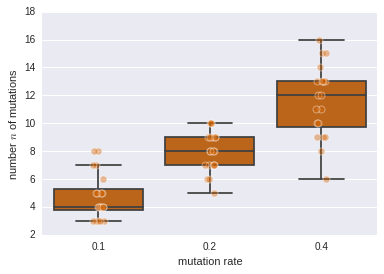

In [60]:
sns.stripplot(data=df[df['k'] == 10], x="M", y="n", alpha=.4, linewidth=1, jitter=.05, color="#d66300")
ax = sns.boxplot(data=df[df['k'] == 10], x="M", y="n", showfliers=False, color="#d66300")
ax.set_xlabel("mutation rate")
ax.set_ylabel("number $n$ of mutations")
plt.savefig("mutations_per_rate.pdf")

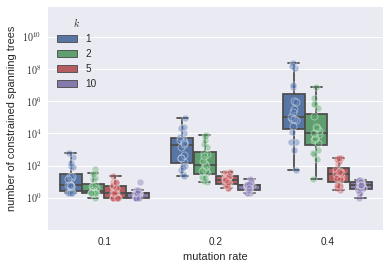

In [61]:
df['logcount'] = np.log10(df['count'])
sns.stripplot(data=df, x="M", y="logcount", hue="k", alpha=.4, split=True, linewidth=1, jitter=.1)
ax = sns.boxplot(data=df, x="M", y="logcount", hue="k", showfliers=False)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], title="$k$", loc="upper left")
ax.set_ylim((-2, 11.9))
ax.set_yticklabels(["", "$10^{0}$", "$10^{2}$", "$10^{4}$", "$10^6$", "$10^8$", "$10^{10}$"])
ax.set_xlabel("mutation rate")
ax.set_ylabel("number of constrained spanning trees")
plt.savefig("solutions_per_rate.pdf")
pass

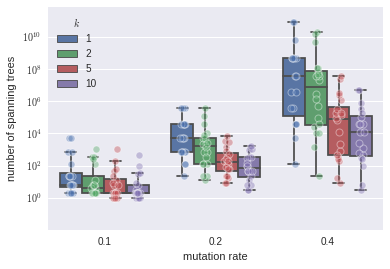

In [62]:
df['logbound'] = np.log10(df['bound'])
sns.stripplot(data=df, x="M", y="logbound", hue="k", split=True, linewidth=1, alpha=.4, jitter=.1)
ax = sns.boxplot(data=df, x="M", y="logbound", hue="k", showfliers=False)
handles, labels = ax.get_legend_handles_labels()
#l = plt.legend(handles[0:4], labels[0:4], title="$k$")
l = plt.legend(handles[0:4], labels[0:4], title="$k$", loc="upper left")
ax.set_ylim((-2, 11.9))
ax.set_yticklabels(["", "$10^{0}$", "$10^{2}$", "$10^{4}$", "$10^6$", "$10^8$", "$10^{10}$"])
ax.set_xlabel("mutation rate")
ax.set_ylabel("number of spanning trees")
plt.savefig("spanning_trees_per_rate.pdf")

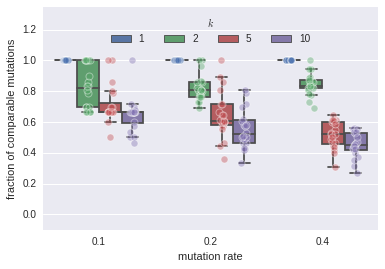

In [63]:
sns.stripplot(data=df, x="M", y="inc", hue="k", alpha=.4, jitter=.1, linewidth=1, split=True)
ax = sns.boxplot(data=df, x="M", y="inc", hue="k", showfliers=False)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], title="$k$", ncol=4, loc="upper center")
ax.set_ylim((-0.1, 1.35))
ax.set_xlabel("mutation rate")
ax.set_ylabel("fraction of comparable mutations")
plt.savefig("frac_comparable.pdf")

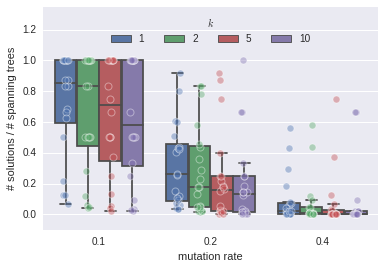

In [64]:
df['ratio'] = df['count'] / df['bound']
sns.stripplot(data=df, x="M", y="ratio", hue="k", alpha=.4, jitter=.1, linewidth=1, split=True)
ax = sns.boxplot(data=df, x="M", y="ratio", hue="k", showfliers=False)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], title="$k$", ncol=4, loc="upper center")
ax.set_ylim((-0.1, 1.35))
ax.set_xlabel("mutation rate")
ax.set_ylabel("# solutions / # spanning trees")
plt.savefig("num_solutions_by_num_spanning_trees.pdf")

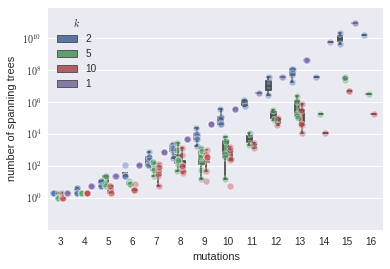

In [33]:
df2 = df.sort_values('n')
sns.stripplot(data=df2, x="n", y="logbound", hue="k", linewidth=1, alpha=.4, jitter=.1)
ax = sns.boxplot(data=df2, x="n", y="logbound", hue="k", showfliers=False)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], title="$k$", loc="upper left")
ax.set_yticklabels(["", "$10^{0}$", "$10^{2}$", "$10^{4}$", "$10^6$", "$10^8$", "$10^{10}$"])
ax.set_xlabel("mutations")
ax.set_ylabel("number of spanning trees")
